### Training part

In [1]:
import sys
# sys.path.append("../input/pretrained-models-pytorch")
# sys.path.append("../input/efficientnet-pytorch")
# sys.path.append("/kaggle/input/smp-github/segmentation_models.pytorch-master")
# sys.path.append("/kaggle/input/timm-pretrained-resnest/resnest/")
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
import segmentation_models_pytorch as smp
import numpy as np



/home/pranav/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp /kaggle/input/timm-pretrained-resnest/resnest/gluon_resnest26-50eb607c.pth /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth

## Config


In [4]:
%%writefile config.yaml

data_path: "/home/pranav/Documents/data/contrails/train_subset"
output_dir: "models/losvasz"

seed: 420

train_bs: 64
valid_bs: 32
workers: 1

progress_bar_refresh_rate: 1

early_stop:
    monitor: "val_loss"
    mode: "min"
    patience: 999
    verbose: 1

trainer:
    max_epochs: 50
    min_epochs: 10
    enable_progress_bar: True
    precision: "16-mixed"
    devices: 1

model:
    seg_model: "Unet"
    encoder_name: "timm-resnest26d"
    loss_smooth: 1.0
    image_size: 256
    optimizer_params:
        lr: 0.00000025
        weight_decay: 0.01 #0.0
    scheduler:
        name: "CosineAnnealingLR"
        params:
            CosineAnnealingLR:
                T_max: 2
                eta_min: 1.0e-6
                last_epoch: -1
            ReduceLROnPlateau:
                mode: "min"
                factor: 0.31622776602
                patience: 4
                verbose: True

Overwriting config.yaml


In [5]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def load_rgb_bands_dir(dir_path):
    band_array = np.load(f'{dir_path}/bands.npy')
    band11 = band_array[3]
    band14 = band_array[6]
    band15 = band_array[7]
    
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    return false_color



def load_label_dir(dir_path):
    label_path = os.path.join(dir_path, 'label.npy')
    band = np.load(label_path)
    label_background = (~np.any(band, axis = -1)).astype(np.uint8)
    # label = np.concatenate([label_background[...,np.newaxis], band], axis = -1)
    label = band
    return label


def load_img_label(path):
    try: path = str(path, 'utf-8')
    except: path = path
    img = load_rgb_bands_dir(path)
    
    label = load_label_dir(path)
    return img.astype(np.float32), label.astype(np.float32)


def load_labeled_data(path):
    image, label = load_img_label(path)
    return image, label

In [6]:
# Dataset

import torch
import numpy as np
import torchvision.transforms as T

class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, path_list, image_size=256, train=True):

        self.path_list = path_list
        self.trn = train
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.image_size = image_size
        if image_size != 256:
            self.resize_image = T.transforms.Resize(image_size)

    def __getitem__(self, index):
        con_path = self.path_list[index]
        img, label = load_labeled_data(con_path)

        label = label.transpose([2,0,1])
        label = torch.tensor(label)

        img = torch.tensor(np.reshape(img, (256, 256, 3))).to(torch.float32).permute(2, 0, 1)

        if self.image_size != 256:
            img = self.resize_image(img)

        img = self.normalize_image(img)

        return img.float(), label.long()

    def __len__(self):
        return len(self.path_list)

In [2]:
# Lightning module

import torch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import AdamW
import torch.nn as nn
from torchmetrics.functional import dice
from lsovaz_loss import Lovasz

seg_models = {
    "Unet": smp.Unet,
    "Unet++": smp.UnetPlusPlus,
    "MAnet": smp.MAnet,
    "Linknet": smp.Linknet,
    "FPN": smp.FPN,
    "PSPNet": smp.PSPNet,
    "PAN": smp.PAN,
    "DeepLabV3": smp.DeepLabV3,
    "DeepLabV3+": smp.DeepLabV3Plus,
}


class LightningModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.model = model = seg_models[config["seg_model"]](
            encoder_name=config["encoder_name"],
            encoder_weights=None,
            in_channels=3,
            classes=2,
            activation=None,
        )
        # self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=config["loss_smooth"])
        self.loss_module = smp.losses.LovaszLoss(mode="multiclass", per_image=True)
        self.loss2 = smp.losses.SoftCrossEntropyLoss(smooth_factor = 0.1, dim = 1)
        self.val_step_outputs = []
        self.val_step_labels = []

    def forward(self, batch):
        imgs = batch
        preds = self.model(imgs)
        return preds

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), **self.config["optimizer_params"])

        if self.config["scheduler"]["name"] == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(
                optimizer,
                **self.config["scheduler"]["params"]["CosineAnnealingLR"],
            )
            lr_scheduler_dict = {"scheduler": scheduler, "interval": "step"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_dict}
        elif self.config["scheduler"]["name"] == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer,
                **self.config["scheduler"]["params"]["ReduceLROnPlateau"],
            )
            lr_scheduler = {"scheduler": scheduler, "monitor": "val_loss"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = 0.9*self.loss_module(preds, labels)+self.loss2(preds, labels[:,0])
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=16)

        for param_group in self.trainer.optimizers[0].param_groups:
            lr = param_group["lr"]
        self.log("lr", lr, on_step=True, on_epoch=False, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        if self.config["image_size"] != 256:
            preds = torch.nn.functional.interpolate(preds, size=256, mode='bilinear')
        loss = 0.9*self.loss_module(preds, labels)+self.loss2(preds, labels[:,0])
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_step_outputs.append(preds[:,1:2])
        self.val_step_labels.append(labels)

    def on_validation_epoch_end(self):
        # pass
        all_preds = torch.cat(self.val_step_outputs)
        all_labels = torch.cat(self.val_step_labels)
        all_preds = torch.sigmoid(all_preds)
        self.val_step_outputs.clear()
        self.val_step_labels.clear()
        val_dice = dice(all_preds, all_labels.long())
        self.log("val_dice", val_dice, on_step=False, on_epoch=True, prog_bar=True)
        if self.trainer.global_rank == 0:
            print(f"\nEpoch: {self.current_epoch}", flush=True)

In [8]:
# Actual training

import warnings

warnings.filterwarnings("ignore")

import os
import torch
import yaml
import pandas as pd
import pytorch_lightning as pl
from pprint import pprint
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, TQDMProgressBar
from torch.utils.data import DataLoader
torch.set_float32_matmul_precision("medium")
# torch.cuda.empty_cache()

with open("config.yaml", "r") as file_obj:
    config = yaml.safe_load(file_obj)

# contrails = os.path.join(config["data_path"], "contrails/")
# train_path = os.path.join(config["data_path"], "train_df.csv")
# valid_path = os.path.join(config["data_path"], "valid_df.csv")
train_path = '/home/pranav/Documents/data/contrails/train_subset'
train_dirs_full = os.listdir(train_path)
train_paths = [os.path.join(train_path, i) for i in train_dirs_full]
val_path = '/home/pranav/Documents/data/contrails/val_subset'
val_dirs_full = os.listdir(val_path)
val_paths = [os.path.join(val_path, i) for i in val_dirs_full]
# train_paths, val_paths = train_test_split(all_paths, test_size=0.1, random_state=42)

# train_df = pd.read_csv(train_path)
# valid_df = pd.read_csv(valid_path)

# train_df["path"] = contrails + train_df["record_id"].astype(str) + ".npy"
# valid_df["path"] = contrails + valid_df["record_id"].astype(str) + ".npy"

dataset_train = ContrailsDataset(train_paths, config["model"]["image_size"], train=True)
dataset_validation = ContrailsDataset(val_paths, config["model"]["image_size"], train=False)

data_loader_train = DataLoader(
    dataset_train,
    batch_size=config["train_bs"],
    shuffle=True,
    num_workers=config["workers"],
)
data_loader_validation = DataLoader(
    dataset_validation,
    batch_size=config["valid_bs"],
    shuffle=False,
    num_workers=config["workers"],
)

checkpoint_callback = ModelCheckpoint(
    save_weights_only=True,
    monitor="val_dice",
    dirpath=config["output_dir"],
    mode="max",
    filename="model",
    save_top_k=1,
    verbose=1,
)

progress_bar_callback = TQDMProgressBar(
    refresh_rate=config["progress_bar_refresh_rate"]
)

early_stop_callback = EarlyStopping(**config["early_stop"])

trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback, progress_bar_callback],
    **config["trainer"],
)

config["model"]["scheduler"]["params"]["CosineAnnealingLR"]["T_max"] *= len(data_loader_train)/config["trainer"]["devices"]
# model = LightningModule(config["model"])
model = LightningModule.load_from_checkpoint('models/losvasz/model-v2.ckpt', config = config["model"])

trainer.fit(model, data_loader_train, data_loader_validation) #, ckpt_path = 'models/losvasz/model.ckpt')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                 | Params
-----------------------------------------------------
0 | model       | Unet                 | 24.0 M
1 | loss_module | LovaszLoss           | 0     
2 | loss2       | SoftCrossEntropyLoss | 0     
-----------------------------------------------------
24.0 M    Trainable params
0         Non-trainable params
24.0 M    Total params
96.135    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]
Epoch: 0
Epoch 0: 100%|██████████| 254/254 [02:06<00:00,  2.01it/s, v_num=84, train_loss_step=0.280, lr=6.23e-7]
Epoch: 0
Epoch 0: 100%|██████████| 254/254 [02:16<00:00,  1.86it/s, v_num=84, train_loss_step=0.280, lr=6.23e-7, val_loss=0.332, val_dice=0.467, train_loss_epoch=0.295]

Metric val_loss improved. New best score: 0.332
Epoch 0, global step 254: 'val_dice' reached 0.46695 (best 0.46695), saving model to '/home/pranav/Documents/segmentation/models/losvasz/model-v3.ckpt' as top 1


Epoch 1: 100%|██████████| 254/254 [02:07<00:00,  1.99it/s, v_num=84, train_loss_step=0.311, lr=1e-6, val_loss=0.332, val_dice=0.467, train_loss_epoch=0.295]   
Epoch: 1
Epoch 1: 100%|██████████| 254/254 [02:17<00:00,  1.85it/s, v_num=84, train_loss_step=0.311, lr=1e-6, val_loss=0.331, val_dice=0.469, train_loss_epoch=0.294]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.331
Epoch 1, global step 508: 'val_dice' reached 0.46863 (best 0.46863), saving model to '/home/pranav/Documents/segmentation/models/losvasz/model-v3.ckpt' as top 1


Epoch 2: 100%|██████████| 254/254 [02:08<00:00,  1.97it/s, v_num=84, train_loss_step=0.287, lr=6.27e-7, val_loss=0.331, val_dice=0.469, train_loss_epoch=0.294]
Epoch: 2
Epoch 2: 100%|██████████| 254/254 [02:19<00:00,  1.83it/s, v_num=84, train_loss_step=0.287, lr=6.27e-7, val_loss=0.330, val_dice=0.468, train_loss_epoch=0.292]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.330
Epoch 2, global step 762: 'val_dice' was not in top 1


Epoch 3: 100%|██████████| 254/254 [02:09<00:00,  1.96it/s, v_num=84, train_loss_step=0.321, lr=2.5e-7, val_loss=0.330, val_dice=0.468, train_loss_epoch=0.292] 
Epoch: 3
Epoch 3: 100%|██████████| 254/254 [02:19<00:00,  1.81it/s, v_num=84, train_loss_step=0.321, lr=2.5e-7, val_loss=0.330, val_dice=0.468, train_loss_epoch=0.291]

Epoch 3, global step 1016: 'val_dice' was not in top 1


Epoch 4: 100%|██████████| 254/254 [02:12<00:00,  1.92it/s, v_num=84, train_loss_step=0.283, lr=6.23e-7, val_loss=0.330, val_dice=0.468, train_loss_epoch=0.291]
Epoch: 4
Epoch 4: 100%|██████████| 254/254 [02:23<00:00,  1.77it/s, v_num=84, train_loss_step=0.283, lr=6.23e-7, val_loss=0.329, val_dice=0.467, train_loss_epoch=0.291]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.329
Epoch 4, global step 1270: 'val_dice' was not in top 1


Epoch 5: 100%|██████████| 254/254 [02:10<00:00,  1.94it/s, v_num=84, train_loss_step=0.281, lr=1e-6, val_loss=0.329, val_dice=0.467, train_loss_epoch=0.291]   
Epoch: 5
Epoch 5: 100%|██████████| 254/254 [02:21<00:00,  1.80it/s, v_num=84, train_loss_step=0.281, lr=1e-6, val_loss=0.329, val_dice=0.469, train_loss_epoch=0.290]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.329
Epoch 5, global step 1524: 'val_dice' reached 0.46870 (best 0.46870), saving model to '/home/pranav/Documents/segmentation/models/losvasz/model-v3.ckpt' as top 1


Epoch 6: 100%|██████████| 254/254 [02:12<00:00,  1.92it/s, v_num=84, train_loss_step=0.329, lr=6.27e-7, val_loss=0.329, val_dice=0.469, train_loss_epoch=0.290]
Epoch: 6
Epoch 6: 100%|██████████| 254/254 [02:23<00:00,  1.77it/s, v_num=84, train_loss_step=0.329, lr=6.27e-7, val_loss=0.329, val_dice=0.469, train_loss_epoch=0.290]

Epoch 6, global step 1778: 'val_dice' was not in top 1


Epoch 7: 100%|██████████| 254/254 [02:09<00:00,  1.96it/s, v_num=84, train_loss_step=0.289, lr=2.5e-7, val_loss=0.329, val_dice=0.469, train_loss_epoch=0.290] 
Epoch: 7
Epoch 7: 100%|██████████| 254/254 [02:20<00:00,  1.81it/s, v_num=84, train_loss_step=0.289, lr=2.5e-7, val_loss=0.329, val_dice=0.469, train_loss_epoch=0.289]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.329
Epoch 7, global step 2032: 'val_dice' reached 0.46934 (best 0.46934), saving model to '/home/pranav/Documents/segmentation/models/losvasz/model-v3.ckpt' as top 1


Epoch 8: 100%|██████████| 254/254 [02:10<00:00,  1.94it/s, v_num=84, train_loss_step=0.288, lr=6.23e-7, val_loss=0.329, val_dice=0.469, train_loss_epoch=0.289]
Epoch: 8
Epoch 8: 100%|██████████| 254/254 [02:21<00:00,  1.79it/s, v_num=84, train_loss_step=0.288, lr=6.23e-7, val_loss=0.329, val_dice=0.468, train_loss_epoch=0.288]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.329
Epoch 8, global step 2286: 'val_dice' was not in top 1


Epoch 9:  96%|█████████▋| 245/254 [02:06<00:04,  1.93it/s, v_num=84, train_loss_step=0.278, lr=9.99e-7, val_loss=0.329, val_dice=0.468, train_loss_epoch=0.288]

## Train Finished

In [8]:
len(dataset_validation)

1856

In [8]:
img, label = next(iter(data_loader_train))

In [10]:
label.shape

torch.Size([64, 1, 256, 256])

TypeError: Invalid shape (1, 256, 256) for image data

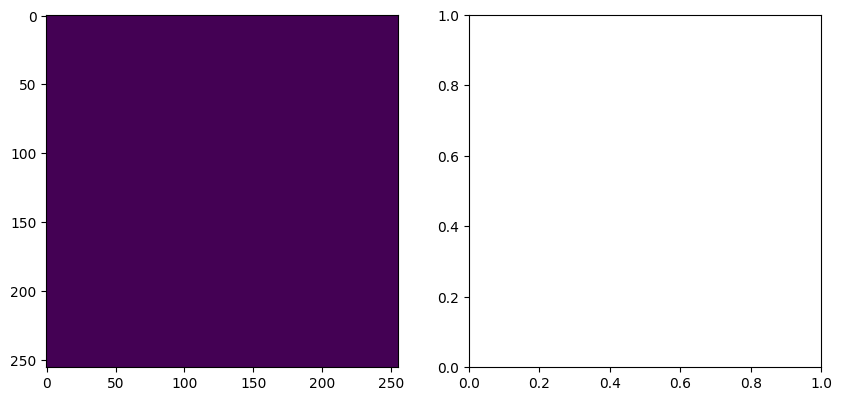

In [11]:
import matplotlib.pyplot as plt
# img, label = dataset_validation.__getitem__(86)
# plt.imshow(img.numpy().transpose([1,2,0]))
# plt.imshow(label.numpy())
model.eval()
model.zero_grad()
with torch.no_grad():
    pred = model(img.cuda())
fig, axs = plt.subplots(1,2, figsize = (10,10))
axs[0].imshow(torch.softmax(pred, 1).cpu().numpy()[0][1]>0.5, vmin=0, vmax=1)
axs[1].imshow(label.numpy()[0])

In [29]:
torch.softmax(pred, 1)[0][1].max()

tensor(0.9107, device='cuda:0')

### Submission part

In [7]:
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
data_root = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test/'

In [8]:
filenames = os.listdir(data_root)
test_df = pd.DataFrame(filenames, columns=['record_id'])
test_df['path'] = data_root + test_df['record_id'].astype(str)

In [9]:
class ContrailsDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_size=256, train=True):
        
        self.df = df
        self.trn = train
        self.df_idx: pd.DataFrame = pd.DataFrame({'idx': os.listdir(f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/test')})
        self.normalize_image = T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        self.image_size = image_size
        if image_size != 256:
            self.resize_image = T.transforms.Resize(image_size)
    
    def read_record(self, directory):
        record_data = {}
        for x in [
            "band_11", 
            "band_14", 
            "band_15"
        ]:

            record_data[x] = np.load(os.path.join(directory, x + ".npy"))

        return record_data

    def normalize_range(self, data, bounds):
        """Maps data to the range [0, 1]."""
        return (data - bounds[0]) / (bounds[1] - bounds[0])
    
    def get_false_color(self, record_data):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        
        N_TIMES_BEFORE = 4

        r = self.normalize_range(record_data["band_15"] - record_data["band_14"], _TDIFF_BOUNDS)
        g = self.normalize_range(record_data["band_14"] - record_data["band_11"], _CLOUD_TOP_TDIFF_BOUNDS)
        b = self.normalize_range(record_data["band_14"], _T11_BOUNDS)
        false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
        img = false_color[..., N_TIMES_BEFORE]

        return img
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        con_path = row.path
        data = self.read_record(con_path)    
        
        img = self.get_false_color(data)
        
        img = torch.tensor(np.reshape(img, (256, 256, 3))).to(torch.float32).permute(2, 0, 1)
        
        if self.image_size != 256:
            img = self.resize_image(img)
        
        img = self.normalize_image(img)
        
        image_id = int(self.df_idx.iloc[index]['idx'])
            
        return img.float(), torch.tensor(image_id)
    
    def __len__(self):
        return len(self.df)

In [10]:
test_ds = ContrailsDataset(
        test_df,
        config["model"]["image_size"],
        train = False
    )
 
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers = 1)

In [8]:
class LightningModule(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = smp.Unet(encoder_name="timm-resnest26d",
                              encoder_weights=None,
                              in_channels=3,
                              classes=2,
                              activation=None,
                              )

    def forward(self, batch):
        return self.model(batch)

In [9]:
model_t = LightningModule().load_from_checkpoint("models/losvasz/model-v4.ckpt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_t.to(device)
model_t.eval()
model_t.zero_grad()

In [13]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [14]:
submission = pd.read_csv('/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv', index_col='record_id')

In [15]:
for i, data in enumerate(test_dl):
    images, image_id = data
    
    images = images.to(device)
    with torch.no_grad():
        predicted_mask = model.forward(images[:, :, :, :])
    if config["model"]["image_size"] != 256:
        predicted_mask = torch.nn.functional.interpolate(predicted_mask, size=256, mode='bilinear')
    predicted_mask = torch.sigmoid(predicted_mask).cpu().detach().numpy()
    
    predicted_mask_with_threshold = np.zeros((images.shape[0], 256, 256))
    predicted_mask_with_threshold[predicted_mask[:, 0, :, :] < 0.5] = 0
    predicted_mask_with_threshold[predicted_mask[:, 0, :, :] > 0.5] = 1
    
    for img_num in range(0, images.shape[0]):
        current_mask = predicted_mask_with_threshold[img_num, :, :]
        current_image_id = image_id[img_num].item()
        
        submission.loc[int(current_image_id), 'encoded_pixels'] = list_to_string(rle_encode(current_mask))

In [16]:
submission

,encoded_pixels
record_id,
1000834164244036115,-
1002653297254493116,-


In [17]:
submission.to_csv('submission.csv')